In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import scipy.stats as stat
import scipy
import seaborn as sns
import pandas as pd
import math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
sns.set_style("whitegrid")

# Race Models

Race models have only one boundary.

In [3]:
class race():
    """
    Simulate a race diffusion Model.
    """

    def __init__(self, A=1.0, v=[1], z=None, s=1, ter=0.3, dt=0.01):
        # Simulation parameters
        self.v = v      # Evidence accumulation rates
        self.A = A      # Decision threshold
        self.s = s      # Noise in accumulation
        self.ter = ter  # Non-decision time (e.g., perception and motor execution)
        self.dt = dt

    def run(self, max_time = 10):
        """Runs a trial"""
        # Set up
        rates = self.v
        noise = self.s
        t = self.ter/self.dt
        threshold = self.A
        time = self.ter
        dt = self.dt

        # Storing variables
        rt = 0
        choice = None
        
        E = [np.zeros(len(rates))]
        
        for i in range(int(t)):
            E.append(np.zeros(len(rates)))  # Starting point for evidence accumulation
        
        # Process
        
        while choice is None and time < max_time:
            newE = np.zeros(len(rates))
            oldE = E[-1]
            for i, drift in enumerate(rates):
                dE = np.random.normal(drift * dt, (noise**2) * np.sqrt(dt))
                newE[i] = oldE[i] + dE 
                if newE[i] > threshold:
                    choice = i
            E.append(newE)
            time += dt

        if choice is not None:
            rt = time
        else:
            rt = time      # Indicates timeout
            choice = np.nan  # No decision made

        return (E, rt, choice)


Here is a visualization

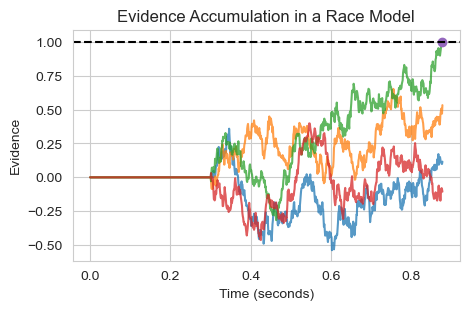

In [5]:
model = race(v=[0.2, 1, 0.7, 0.5], dt=0.001)
E, rt, choice = model.run()
xtime = np.arange(0, rt + model.dt/2, model.dt)
plt.figure(figsize=(5,3))
plt.plot(xtime, E, alpha=0.75)
plt.plot(rt, model.A, "o")
plt.title("Evidence Accumulation in a Race Model")
plt.xlabel("Time (seconds)")
plt.ylabel("Evidence")
plt.axhline(y=1, color='k', linestyle='--', alpha=1)
plt.savefig("figures/race_example.png")
plt.show()

## The Leaky Competitive Accumulator model

In [7]:
class lca():
    """
    Simulate a LCA model.
    """

    def __init__(self, A=1.0, v=[1], kappa=0.1, beta=0.01, s=1, ter=0.3, dt=0.01):
        # Simulation parameters
        self.v = v      # Evidence accumulation rates
        self.A = A      # Decision threshold
        self.s = s      # Noise in accumulation
        self.ter = ter  # Non-decision time (e.g., perception and motor execution)
        self.dt = dt
        self.kappa = kappa
        self.beta = beta

    def run(self, max_time = 10):
        """Runs a trial"""
        # Set up
        rates = self.v
        N = len(rates)
        noise = self.s
        k = self.kappa
        b = self.beta
        t = self.ter/self.dt
        threshold = self.A
        time = self.ter
        dt = self.dt

        # Storing variables
        rt = 0
        choice = None
        
        E = [np.zeros(N)]
        
        for i in range(int(t)):
            E.append(np.zeros(N))  # Starting point for evidence accumulation
        
        # Process
        
        while choice is None and time < max_time:
            newE = np.zeros(N)
            oldE = E[-1]
            for i, drift in enumerate(rates):
                mask = np.ones(N)
                mask[i] = 0
                Inpt = np.random.normal(drift*dt, (noise**2) * np.sqrt(dt))
                Leak = oldE[i] * k * dt
                Cmpt = np.sum(oldE * mask * b) * dt
                dE = Inpt - Leak - Cmpt
                newE[i] = oldE[i] + dE 
                if newE[i] > threshold:
                    choice = i
            E.append(newE)
            time += dt

        if choice is not None:
            rt = time
        else:
            rt = time      # Indicates timeout
            choice = np.nan  # No decision made

        return (E, rt, choice)


In [8]:
z = np.zeros(5)
o = np.ones(5)
z * o

array([0., 0., 0., 0., 0.])

Here is a visualization

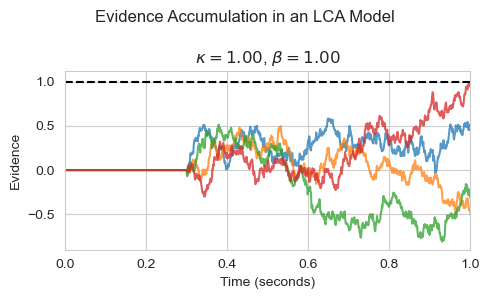

In [10]:
model = lca(v=[1, 0.2, 0.3, 0.5], kappa = 1, beta=1, dt=0.001)
E, rt, choice = model.run()
xtime = np.arange(0, rt + model.dt/2, model.dt)
plt.figure(figsize=(5,3))
plt.plot(xtime, E, alpha=0.75)
plt.xlim(0, 1)
plt.plot(rt, model.A, "o")
plt.suptitle("Evidence Accumulation in an LCA Model")
plt.title(r"$\kappa = %.2f$, $\beta = %.2f$" % (model.kappa, model.beta))
plt.xlabel("Time (seconds)")
plt.ylabel("Evidence")
plt.axhline(y=1, color='k', linestyle='--', alpha=1)
plt.tight_layout()
plt.savefig("figures/race_example.png")
plt.show()

## The Linear Ballistic Accumulator model 

The LBA is a random-ray model. The drift rate is the angle at which the ray is moving towards the boundary. Inter-trial variability comes from teh angle being drawn from a normal distribution.

In [107]:
class LBA:
    """Brown and Heathcote's Linear Ballistic Accumulator""" 
    def __init__(self, v=1, a=1, ter=0.3, vsd=0.1):
        """Initializes the main parameters"""
        self.v = v
        self.a = a
        self.ter = ter
        self.vsd = vsd
        
    def run(self, max_time = 5):
        """Simulates a single trial as a random ray"""
        slope = np.max((0.000000001, np.random.normal(self.v, self.vsd)))
        start = np.random.uniform(0, self.a)
        intersect = (self.a - start) / slope
        rt = np.min((max_time, self.ter + intersect))         
        return (rt, slope, start)
    


Here is an illustration of the LBA in action

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_2120/165759763.py:46: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.2`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(data=data, x='rts', ax=axs1, fill=True, bw=0.2)


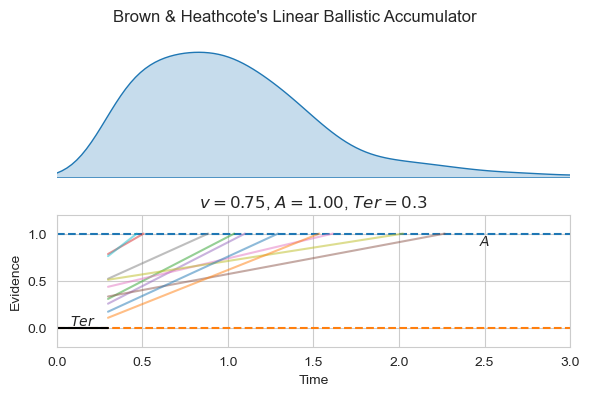

In [135]:
lba = LBA(v = 0.75, a = 1, ter=0.3, vsd=0.3)

N= 1000
trials = []
for i in range(N):
    trials.append(lba.run())

rts = [x[0] for x in trials]
ks = [x[2] for x in trials]
data = pd.DataFrame({"rts":rts})
#sns.kdeplot(data=data, fill=True)

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 1]})
max_time = 3

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)

for ax in (axs1,):#, axs3):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

axs2.set_ylim(-0.2, lba.a + 0.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, max_time], [lba.a, lba.a], '--')
axs2.plot([0, max_time], [0, 0], '--')
axs2.plot([0, lba.ter], [0, 0], "k")

axs2.text(s=r"$Ter$", x=lba.ter/2, y = 0, ha='center', va = 'bottom')
axs2.text(s=r"$A$", x=max_time - 0.5, y = lba.a, ha='center', va = 'top')

subset = rnd.sample([x for x in trials if x[0] < max_time], k = 10)

for trace in subset:
    rt, v, k = trace
    axs2.plot([lba.ter, rt], [k, lba.a], alpha=0.5)

bins = [x/2 for x in range(0, 2*max_time)]
axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (lba.v, lba.a, lba.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
sns.kdeplot(data=data, x='rts', ax=axs1, fill=True, bw=0.2)
fig.suptitle("Brown & Heathcote's Linear Ballistic Accumulator")
fig.tight_layout()
#plt.savefig("figures/lba.png", dpi=200)
plt.show()

#print(np.mean(rts))
#print(0.3 + 0.5/0.75)

# Fitting an Accumulator Model

Now we are going to demonstrate how we can fit a DDM model to real data.   


In [139]:
data = pd.read_csv('simon_data.csv')
data

,Participant,Trial,Position,TrialType,Correct,RT
0,42012,13,Right,C,1,729
1,42012,14,Right,C,1,435
2,42012,15,Right,C,1,377
3,42012,16,Left,C,1,352
4,42012,17,Left,C,1,329
5,42012,18,Left,I,1,611
6,42012,19,Left,C,1,834
7,42012,20,Right,C,1,520
8,42012,21,Right,C,1,459
9,42012,22,Right,I,1,575


We are going to plot the histogram of response times together with the estimated probability distrubution

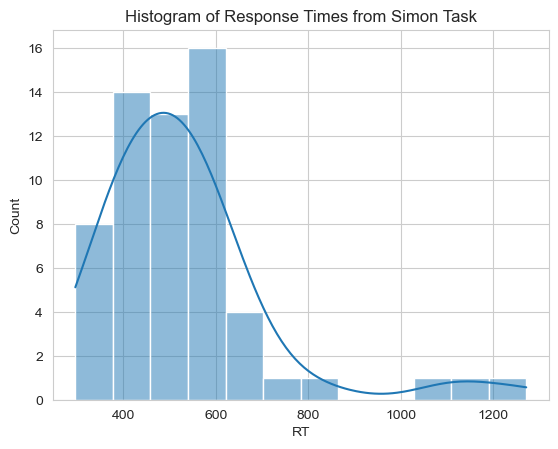

In [141]:
ax = sns.histplot(data, x="RT", kde=True)
ax.set_title("Histogram of Response Times from Simon Task")
plt.show()

## Loss Function

Since we are going to reproduce the distribution of RTs, we are going to use the Kullback-Leiber divergence $D_{KL}$:

$$ D_{KL}(P||Q) = \int_x P(x) \times \log \frac{P(x)}{Q(x)}$$

The KL divergence measures hhow much the distribution $P$ difference from $Q$; formally, it can be interpreted as the increase _surprise_ that is observed if one replaces $P$ with $Q$. In our case, $Q$ is the model's prediction and $P$ is the empirical data:

$$ D_{KL}(P||Q) = \int_x P_{data}(x) \times \log \frac{P_{data}(x)}{P_{model}(x)}$$

In practice, we always deal with finite distributions and samples:

$$ D_{KL}(P||Q) = \sum_{i=1}^n   P_{data}(i) \times \log \frac{P_{data}(i)}{P_{model}(i)} $$

## Computing Probability Densities

Note that the KL function is computed over a series of _probabilities_, which must be between 0 and 1 (and must be strictly > 0, because of the logarithm and the fraction). What we do have is instead a histogram of values. To turn histograms into probabilities, we can use a _kernel density estimator_ (KDE):

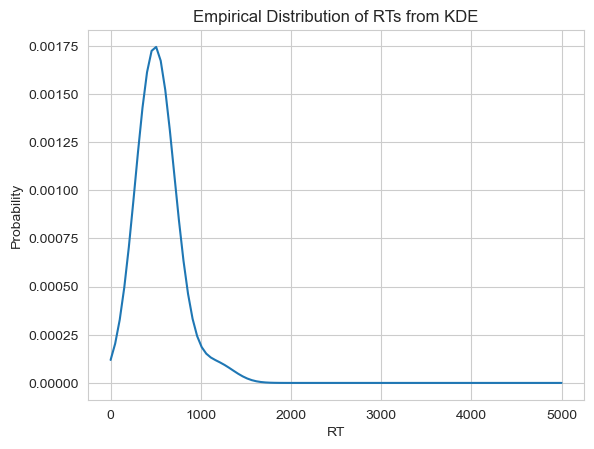

In [434]:
empirical_kde = stat.gaussian_kde(data.RT, bw_method=1)
x = np.linspace(0, 5000, 100)
empirical_dist = [empirical_kde(i) for i in x]
plt.plot(x, empirical_dist)
plt.title("Empirical Distribution of RTs from KDE")
plt.xlabel("RT")
plt.ylabel("Probability")
plt.show()

Now we can define our loss function. It takes a vector of parameters $\theta = {v, A, T_{ER}, SD_v}$ and does the following:

* It creates a new LBA model with the parameters in $\theta$;
* Runs the LBA model 10,000 times and collectes the response times.
* Computes the distribution fo RTs using Kernel Density estimation/
* Computes the KL divergence using the probability values estimated from the KDE of the empirical data and the KDE of the model's responses
* Returns the value of the KL divergence.

In [448]:
def loss(X):
    v, ter, a, vsd = X 
    lba = LBA(v = v, ter=ter, a= a, vsd = vsd)
    traces = [lba.run(max_time=100) for i in range(10000)]
    predicted = [x[0]*1000 for x in traces]
    model_kde = stat.gaussian_kde(np.array(predicted))
    model_dist = [model_kde(x) for x in np.linspace(0, 5000, 100)]
    
    return stat.entropy(empirical_dist, model_dist)

aspace = np.linspace(0.01, 0.8, 10)
vspace = np.linspace(0.01, 0.8, 10)
matrix = np.zeros((len(aspace), len(vspace)))

for i, a in enumerate(aspace):
    for j, v in enumerate(vspace):
        matrix[i,j] = loss(np.array([v, 0.25, a, 0.25]))
matrix

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_2120/1337523600.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i,j] = loss(np.array([v, 0.25, a, 0.25]))


array([[1.56347382, 1.55791061, 1.54247319, 1.50035304, 1.42130224,
        1.26639616, 0.99056729, 0.64513034, 0.35837111, 0.17996801],
       [1.57845811, 1.57187305, 1.55499292, 1.52256459, 1.44931141,
        1.29681568, 1.04875725, 0.60498111, 0.44057338, 0.13460283],
       [1.58907568, 1.5818942 , 1.56550336, 1.53765301, 1.46461306,
        1.35224313, 1.04994725, 0.74278337, 0.3824991 , 0.14332447],
       [1.60003296, 1.59192867, 1.57491853, 1.54396079, 1.48326382,
        1.35981512, 1.04467727, 0.77325721, 0.46725275, 0.19935895],
       [1.60676385, 1.599512  , 1.58456241, 1.5570251 , 1.50466614,
        1.3905962 , 1.18674358, 0.83418155, 0.40404823, 0.0881048 ],
       [1.61513224, 1.6069685 , 1.59356871, 1.56804835, 1.5143927 ,
        1.38720373, 1.23573133, 0.82963291, 0.53224641, 0.20433712],
       [1.62123477, 1.61335642, 1.60016255, 1.57516205, 1.52987307,
        1.41312952, 1.2632393 , 0.84609338, 0.58385904, 0.19395563],
       [1.62815578, 1.62026754, 1.6068705

And now we can visualize the results

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_2120/4145688086.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in aspace])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_2120/4145688086.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in vspace])


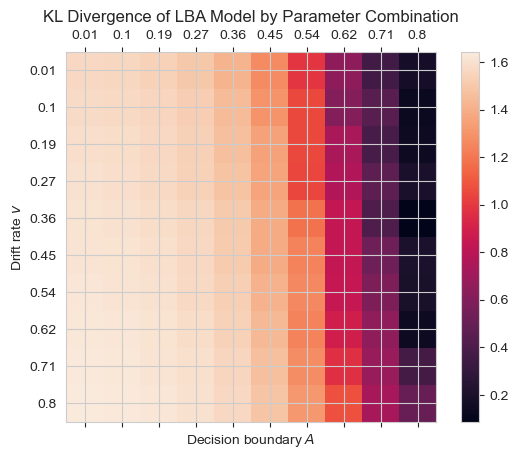

In [450]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in aspace])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in vspace])
ax.set_xlabel(r"Decision boundary $A$ ")
ax.set_ylabel(r"Drift rate $v$ ")
ax.set_title("KL Divergence of LBA Model by Parameter Combination")
plt.show()

With the loss function in place, we now can apply, again, standard optimization techniques. This time we are going to use _Powell_'s method (instead o the Nelder-Mead algorithm) because it allows for the specification fo boundaries for the space of each parameter. These boundaries are needed because some values are constrained. For example, all parameter values must be positive.

In [452]:
res = scipy.optimize.minimize(loss, x0=[0.25, 0.5, 1, 0.5],
                              method="Powell", bounds=[[0.1, 1], 
                                                       [0.1, 0.3], 
                                                       [0.0001, 1],
                                                       [0.0001, 0.5]],
                             tol=0.1)
print(res)

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_2120/3016613514.py:1: OptimizeWarning: Initial guess is not within the specified bounds
  res = scipy.optimize.minimize(loss, x0=[0.25, 0.5, 1, 0.5],
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2291: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2292: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.10253909435024053
       x: [ 9.188e-01  1.764e-01  5.242e-01  2.640e-01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
    nfev: 42


And now, we can visualize how well our midel's distribution of RTs matches the results from the Simon experiment.

[0.91884705 0.1763932  0.52421933 0.26397924]
0.024036371162117123


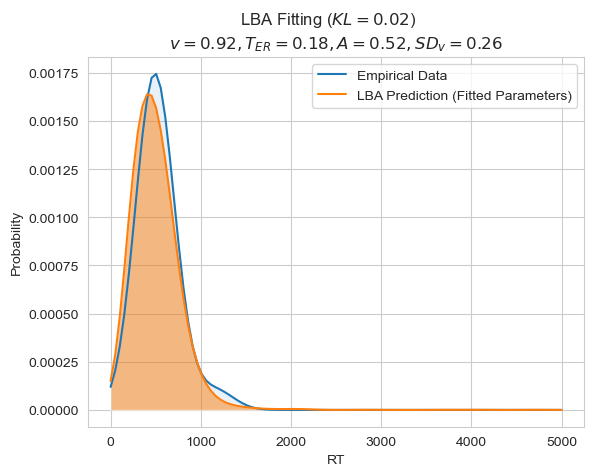

In [460]:
# Generate high-density RT space for better viz
rtx = np.linspace(0, 5000, 100)

# Re-generate empirical RT Distribution

empirical_dist = [empirical_kde(i) for i in rtx]
empirical_dist = np.array(empirical_dist).reshape(100)

# RT Dist with default values

lba = LBA(v=3, ter=2, a=1, vsd=0.1)
traces = [lba.run(max_time=100) for i in range(10000)]
predicted = [x[0]*1000 for x in traces]
labdist = stat.gaussian_kde(predicted)
default_dist = [labdist(i) for i in rtx]

# RT Dist with Optimized values

vstar, terstar, astar, vsdstar = res.x
print(res.x)

lbastar = LBA(v=vstar, ter=terstar, a=astar, vsd=vsdstar)
traces = [lbastar.run(max_time=100) for i in range(5000)]
predicted = [x[0]*1000 for x in traces]
labdist = stat.gaussian_kde(predicted, bw_method=0.5)
optimized_dist = [labdist(i) for i in rtx]
optimized_dist = np.array(optimized_dist).reshape(100)

# Compute KL

kl = stat.entropy(empirical_dist, optimized_dist)
print(kl)

plt.plot(rtx, empirical_dist, label="Empirical Data")
plt.fill_between(x=rtx, y1=empirical_dist, alpha=0.1)
#plt.plot(rtx, default_dist, label="LBA Prediction (Default Parameters)")

plt.plot(rtx, optimized_dist, label="LBA Prediction (Fitted Parameters)")
plt.fill_between(x=rtx, y1=optimized_dist, alpha=0.5)

plt.legend()
plt.suptitle("LBA Fitting ($KL = %.2f$)" % (kl))
plt.title("$v = %.2f, T_{ER} = %.2f, A= %.2f, SD_v = %.2f$" % (vstar, terstar, astar, vsdstar))
plt.xlabel("RT")
plt.ylabel("Probability")
plt.show()

array([2.76528037e-007, 2.47263044e-006, 1.56377031e-005, 7.09177899e-005,
       2.35221069e-004, 5.86011504e-004, 1.13330245e-003, 1.76567590e-003,
       2.30477919e-003, 2.61804559e-003, 2.65616583e-003, 2.41101506e-003,
       1.92626514e-003, 1.33860814e-003, 8.15627763e-004, 4.51529858e-004,
       2.42815547e-004, 1.33172128e-004, 7.46667601e-005, 5.56327348e-005,
       7.80688194e-005, 1.25705229e-004, 1.63552045e-004, 1.69171177e-004,
       1.50336008e-004, 1.21139495e-004, 8.42858578e-005, 4.57817330e-005,
       1.80405074e-005, 4.97564668e-006, 9.46235017e-007, 1.23346202e-007,
       1.09957003e-008, 6.69722865e-010, 2.78603476e-011, 7.91471500e-013,
       1.53538316e-014, 2.03386064e-016, 1.83968986e-018, 1.13628029e-020,
       4.79229051e-023, 1.38012161e-025, 2.71398866e-028, 3.64430834e-031,
       3.34147794e-034, 2.09208089e-037, 8.94406064e-041, 2.61100308e-044,
       5.20470861e-048, 7.08437991e-052, 6.58451288e-056, 4.17889873e-060,
       1.81099157e-064, 5

## Simulations

In [ ]:
fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 1.5

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)
#axs3.set_xlim(0, max_time)

for ax in (axs1,):#, axs3):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    #ax.set_ylim(0, 2000)`
    #axs3.set_ylim(0, 10)

axs2.set_ylim(-0.2, model.A + 0.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, model.ter], [model.z, model.z], "k")
axs2.plot([0, max_time], [model.A, model.A], '--')
axs2.plot([0, max_time], [0, 0], '--')

axs2.text(s=r"$Ter$", x=model.ter/2, y = model.z, ha='center', va = 'top')
axs2.text(s=r"$A$", x=max_time - 0.5, y = model.A, ha='center', va = 'top')
#axs2.text(s=r"$0$", x=max_time - 0.5, y = 0, ha='center', va = 'bottom')

traces = rnd.choices(runs, k=10)

sns.kdeplot(data, x="rts", hue="choices", ax=axs1, fill=True)

for trace in traces:
    n = len(trace)
    if trace[-1] > model.A:
        trace[-1] = model.A
    elif trace[-1] < 0:
        trace[-1] = 0
    x = np.arange(model.ter + model.dt, model.ter + model.dt * (n+1/2), model.dt)
    axs2.plot(x, trace, linewidth=0.75)

axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (model.v, model.A, model.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")

fig.suptitle("Ratcliff's Drift-Diffusion Model")
fig.tight_layout()
plt.show()
plt.savefig('figures/newddm.jpg')

In [ ]:
1 / (1 + np.exp(-1))